In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE =  256
BATCH_SIZE =  32
CHANNELS = 3

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'Plantvillage',
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) #68 of each 32 images 

68

In [6]:
for image_batch, label_batch in dataset.take(1):
        print(image_batch.shape)
        print(label_batch.numpy())   #32 is total images in dataset.take(1),256,256 is size and 3 is RGB channels

(32, 256, 256, 3)
[1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 1 2 1 0 0 1 1 0 1 2 1 0 1]


In [7]:
for image_batch, label_batch in dataset.take(1):
        print(image_batch[0].numpy())
        

[[[144. 137. 144.]
  [147. 140. 147.]
  [150. 143. 150.]
  ...
  [134. 123. 131.]
  [124. 113. 121.]
  [130. 119. 127.]]

 [[145. 138. 145.]
  [147. 140. 147.]
  [150. 143. 150.]
  ...
  [135. 124. 132.]
  [123. 112. 120.]
  [120. 109. 117.]]

 [[146. 139. 146.]
  [147. 140. 147.]
  [148. 141. 148.]
  ...
  [147. 136. 144.]
  [137. 126. 134.]
  [125. 114. 122.]]

 ...

 [[175. 166. 169.]
  [175. 166. 169.]
  [176. 167. 170.]
  ...
  [157. 146. 150.]
  [147. 136. 140.]
  [150. 139. 143.]]

 [[176. 167. 170.]
  [176. 167. 170.]
  [176. 167. 170.]
  ...
  [114. 103. 107.]
  [161. 150. 154.]
  [134. 123. 127.]]

 [[179. 170. 173.]
  [179. 170. 173.]
  [178. 169. 172.]
  ...
  [160. 149. 153.]
  [167. 156. 160.]
  [132. 121. 125.]]]


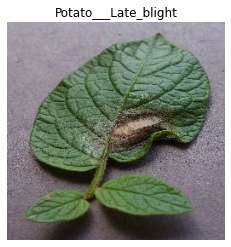

In [8]:
for image_batch, label_batch in dataset.take(1):
        plt.imshow(image_batch[0].numpy().astype("uint8"))
        plt.title(class_names[label_batch[0]])
        plt.axis("off")

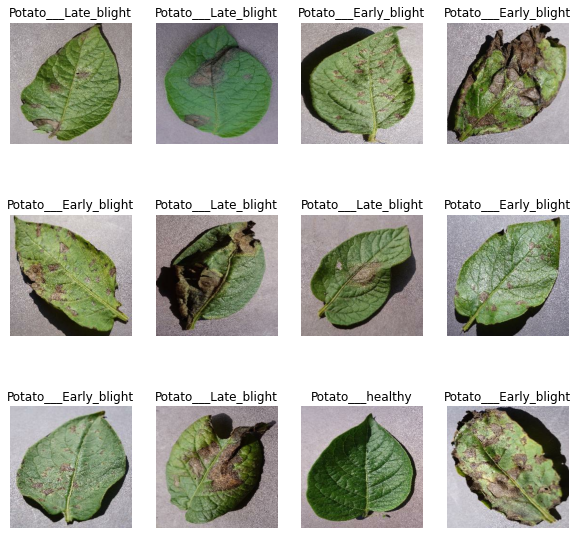

In [9]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

# train test split
# 80% of data for training 
# 10% for validation after training
# 10% for testing the dataset

In [10]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds
    
    

In [11]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(test_ds)

8

In [14]:
len(val_ds)

6

In [15]:
'''Cache and prefetch for optimize the training time and shuffle for creating the randomness in the data
    
 if we use cache then no need of reading the dataset/images for every epochs
 for first epoch it will save the data and reuse it for every epoch
 
 if we use prefetch it optimize the training time by paralleling runnning the cpu and gpu
 
 usually without prefetch cpu will read one batch and gpu train it after that cpu again read 2nd batch untill then cpu is idle
 
 with prefetch cpu and gpu can run parallely at time to save the training time



'''


'Cache and prefetch for optimize the training time and shuffle for creating the randomness in the data\n    \n if we use cache then no need of reading the dataset/images for every epochs\n for first epoch it will save the data and reuse it for every epoch\n \n if we use prefetch it optimize the training time by paralleling runnning the cpu and gpu\n \n usually without prefetch cpu will read one batch and gpu train it after that cpu again read 2nd batch untill then cpu is idle\n \n with prefetch cpu and gpu can run parallely at time to save the training time\n\n\n\n'

In [16]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Rescaling and Resizing the input image

In [17]:
#if other for new classification/prediction of new image outside dataset if it is not in 256,256 size so we have to rescale and resize

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

# DATA AUGUMENTATION

In [19]:
#if the new input image is rotated and with high contrast so trained model can't predict with best accuracy so we have to do data augmention

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

# Model Building

In [21]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = "relu",input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = "relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [23]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics =['accuracy']
)

In [25]:
EPOCHS = 20
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

)

Epoch 1/20
54/54 [==============================] - 333s 6s/step - loss: 0.6106 - accuracy: 0.7309 - val_loss: 0.3189 - val_accuracy: 0.8750
Epoch 2/20
54/54 [==============================] - 327s 6s/step - loss: 0.4013 - accuracy: 0.8391 - val_loss: 0.3854 - val_accuracy: 0.8385
Epoch 3/20
54/54 [==============================] - 305s 6s/step - loss: 0.2377 - accuracy: 0.9068 - val_loss: 0.5168 - val_accuracy: 0.8229
Epoch 4/20
54/54 [==============================] - 350s 7s/step - loss: 0.2174 - accuracy: 0.9190 - val_loss: 0.2928 - val_accuracy: 0.9115
Epoch 5/20
54/54 [==============================] - 362s 7s/step - loss: 0.1630 - accuracy: 0.9363 - val_loss: 0.2940 - val_accuracy: 0.8958
Epoch 6/20
54/54 [==============================] - 327s 6s/step - loss: 0.1610 - accuracy: 0.9340 - val_loss: 0.7016 - val_accuracy: 0.7865
Epoch 7/20
54/54 [==============================] - 313s 6s/step - loss: 0.1561 - accuracy: 0.9369 - val_loss: 0.2447 - val_accuracy: 0.9167
Epoch 8/20
54

In [26]:
scores = model.evaluate(test_ds)


8/8 [==============================] - 140s 1s/step - loss: 0.6565 - accuracy: 0.7773


In [27]:
scores

[0.6564554572105408, 0.77734375]

In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

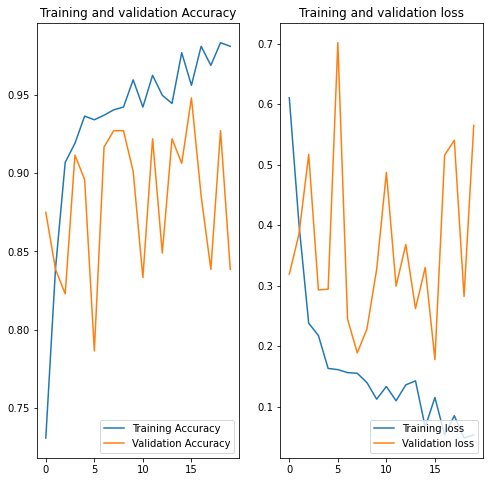

In [35]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation Accuracy')


plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label = 'Training loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation loss')
plt.legend(loc = 'lower right')
plt.title('Training and validation loss')

first image to predict
actual label: Potato___healthy
predicted label: Potato___healthy


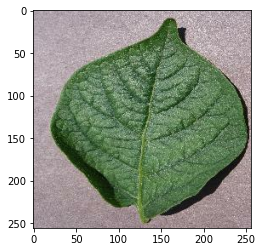

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

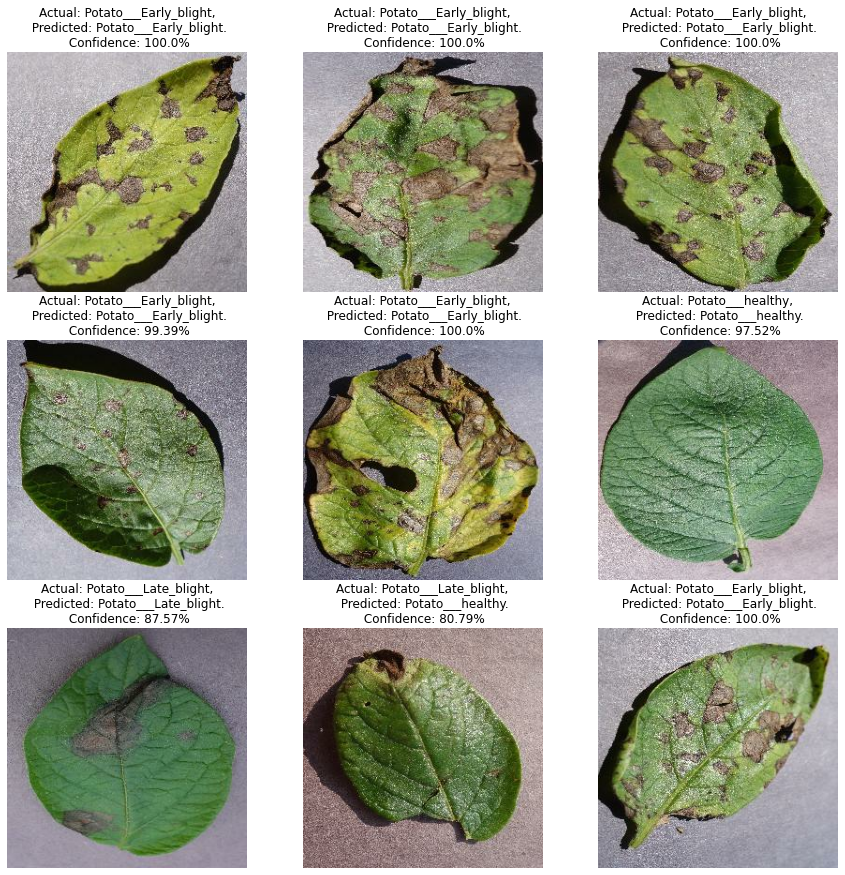

In [40]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [43]:
model_version = 1

model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


# Save the model

In [44]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
